In [1]:
from viresclient import SwarmRequest
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Fetching data

NB: Fetching multiple collections at the same time (i.e. FAC, MAG, EFI) will get data sampled at the timestamps of the first collection given. Mismatched time series will be nearest-neighbour interpolated to the time series of the first collection.

Here we give SW_OPER_FACATMS_2F as the "master" collection (it is given first), so returned data is sampled at the FAC timestamps, which is 1-second cadence, although the EFI datasets are at 0.5-second cadence.

In [2]:
start = dt.datetime(2016,8,27, 17,21,0)
end = dt.datetime(2016,8,27, 17,25,0)

request = SwarmRequest()
request.set_collection(
    "SW_OPER_FACATMS_2F", "SW_OPER_FACCTMS_2F",
    "SW_OPER_MAGA_LR_1B", "SW_OPER_MAGC_LR_1B",
    "SW_OPER_EFIA_LP_1B", "SW_OPER_EFIC_LP_1B"
)
request.set_products(
    measurements=[
        "FAC", "FAC_Error", "Flags", "Flags_F", "Flags_B", "Flags_q",  # FAC parameters
        "B_NEC",  # MAG parameters
        "Ne", "Te"  # EFI parameters
    ],
    models = ["'Model' = 'CHAOS-6-Core' + 'CHAOS-6-Static' + 'CHAOS-6-MMA-Primary' + 'CHAOS-6-MMA-Secondary'"],
    residuals=True,
    auxiliaries=["QDLat", "QDLon"],
)
data = request.get_between(start, end)
df = data.as_dataframe(expand=True)
df.head()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.149MB)


,Spacecraft,Latitude,Longitude,Radius,FAC,FAC_Error,Flags,Flags_F,Flags_B,Flags_q,B_NEC_res_Model_N,B_NEC_res_Model_E,B_NEC_res_Model_C,Ne,Te,QDLat,QDLon
2016-08-27 17:21:00.500,A,50.655545,43.912594,6814320.245,-0.006604,0.062713,0,2,0,0,15.869073,1.005969,-15.896792,122026.4,2005.11,46.729874,117.849144
2016-08-27 17:21:01.500,A,50.719687,43.915837,6814310.050,0.000059,0.061692,0,2,0,0,15.828325,0.971604,-15.853849,121862.8,2066.71,46.796555,117.860184
2016-08-27 17:21:02.500,A,50.783829,43.919100,6814299.870,-0.001132,0.061849,0,2,0,0,15.805112,0.998204,-15.831043,121163.9,2076.01,46.863216,117.871292
2016-08-27 17:21:03.500,A,50.847971,43.922384,6814289.695,-0.006763,0.062673,0,2,0,0,15.779614,1.014154,-15.794431,120066.5,2055.46,46.929867,117.882454
2016-08-27 17:21:04.500,A,50.912112,43.925688,6814279.535,-0.010334,0.063187,0,2,0,0,15.763352,0.980589,-15.753220,119799.9,2107.67,46.996513,117.893692


## Plotting

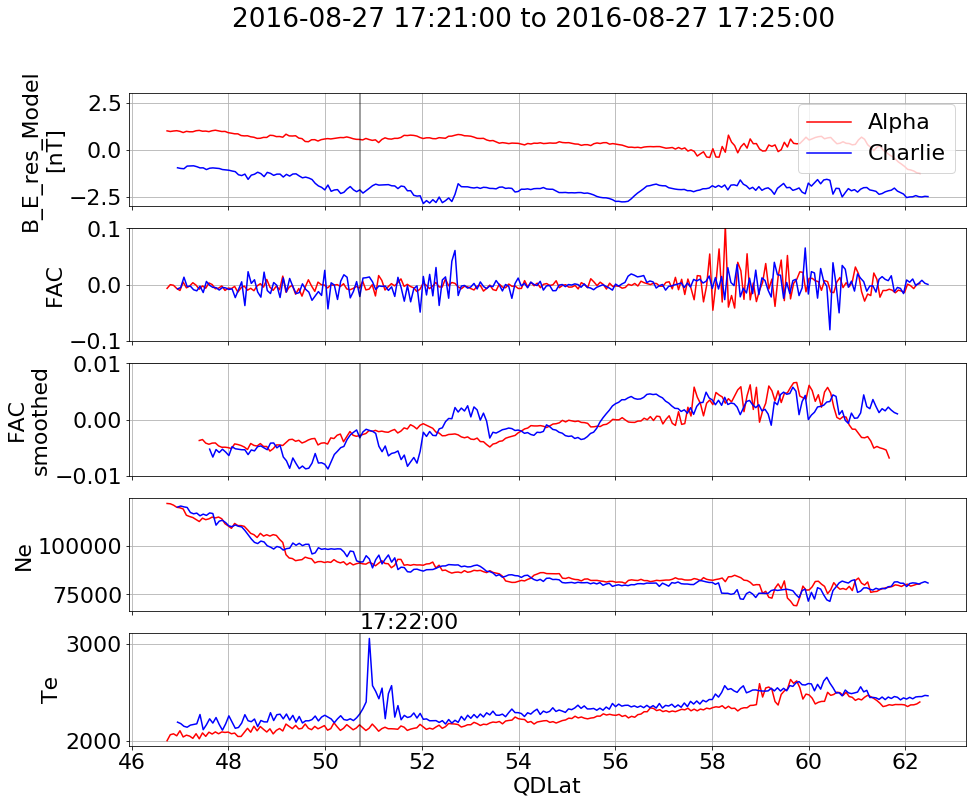

In [4]:
plt.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 12), sharex=True)

df_A = df[df["Spacecraft"] == "A"]
df_C = df[df["Spacecraft"] == "C"]

axes[0].plot(df_A["QDLat"], df_A["B_NEC_res_Model_E"], color="red", label="Alpha")
axes[0].plot(df_C["QDLat"], df_C["B_NEC_res_Model_E"], color="blue", label="Charlie")
axes[0].legend()
axes[0].set_ylabel("B_E_res_Model\n[nT]")
axes[0].set_ylim((-3, 3))

axes[1].plot(df_A["QDLat"], df_A["FAC"], color="red")
axes[1].plot(df_C["QDLat"], df_C["FAC"], color="blue")
axes[1].set_ylabel("FAC")
axes[1].set_ylim((-0.1, .1))

axes[2].plot(df_A["QDLat"], df_A["FAC"].rolling(21, center=True).mean(), color="red")
axes[2].plot(df_C["QDLat"], df_C["FAC"].rolling(21, center=True).mean(), color="blue")
axes[2].set_ylabel("FAC\nsmoothed")
axes[2].set_ylim((-.01, .01))

axes[3].plot(df_A["QDLat"], df_A["Ne"], color="red")
axes[3].plot(df_C["QDLat"], df_C["Ne"], color="blue")
axes[3].set_ylabel("Ne")

axes[4].plot(df_A["QDLat"], df_A["Te"], color="red")
axes[4].plot(df_C["QDLat"], df_C["Te"], color="blue")
axes[4].set_ylabel("Te")

axes[4].set_xlabel("QDLat")

# Draw a vertical line at a given time
vline_time = dt.datetime(2016,8,27, 17,22,0)
vline_qdlat = df_A.iloc[df_A.index.get_loc(vline_time, method='nearest')]["QDLat"]
for ax in axes:
    ax.axvline(vline_qdlat, color="black", alpha=0.5)
# Write the provided time on the graph
axes[4].text(
    vline_qdlat, axes[4].get_ylim()[1],  # x,y location
    vline_time.strftime("%H:%M:%S"),  # formatted time (http://strftime.org)
    verticalalignment="bottom"
)

for ax in axes:
    ax.grid()
    
fig.suptitle(f"{start} to {end}");